In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lmfit import minimize, Parameters, report_fit
from lmfit import Minimizer
import pandas as pd
import glob
import functools

We will be fitting transfer function


\begin{equation*}
F(f)=\prod_{i=0}^{14}\frac{A_0*f^8}{(jf\pm p_i)}
\end{equation*}

where $f$ is frequency on Hz, $p_{i}$ poles of the thansfer function

In [3]:
list_of_devices = ['387']

path = '/'   ## path to folder with calibration data

files = [f for f in glob.glob(path + "**/calib.dat", recursive=True) if any( s in f for s in list_of_devices)]

df = pd.concat(map(functools.partial(pd.read_csv, sep = " ", header = None),files))

df = df.groupby(df[0], as_index = False).mean()   ### mean of all sensors calibrations

##   for one device, comment it if you need mean of several sensors
seis_fr = pd.read_csv("Sens-387/calib.dat", sep = " ", header = None)  

## mean of sensors
#seis_fr = df  

In [4]:
# pole-zeros function, n - number of zeroes, a - a0, p - poles

def poles_to_poly(x,n,a,p):
    
    return(a*(x)**n/ np.polyval(  np.poly(p)    ,x)/np.polyval(  np.poly(np.conj(p))    ,x) )

In [5]:
xdata =(seis_fr.iloc[:,0].values)
ydata = (seis_fr.iloc[:,1].values)

xdata_complex =  seis_fr.iloc[:,0].values/2/np.pi*1j    
ydata_complex = seis_fr.iloc[:,1].values * np.exp(1j * seis_fr.iloc[:,3].values)

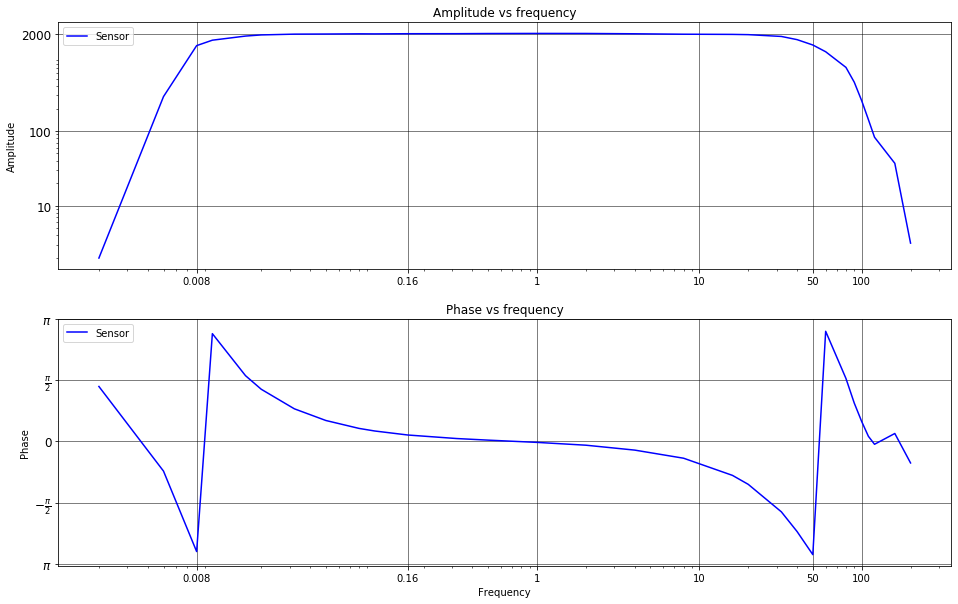

In [6]:
plt.figure(figsize = (16,10))
plt.rc('ytick', labelsize = 12)

plt.subplot(2,1,1)
plt.loglog(xdata, ydata, 'b', label = "Sensor")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.yticks([10,100,2000],['10','100','2000'])
plt.xticks([0.008,0.16,1,10,50,100], ['0.008','0.16','1','10','50','100'])
plt.title("Amplitude vs frequency")
plt.ylabel('Amplitude')
plt.legend(loc = 'upper left')


plt.subplot(2,1,2)
plt.semilogx(xdata,np.angle(ydata_complex),'b', label = "Sensor")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks([0.008,0.16,1,10,50,100], ['0.008','0.16','1','10','50','100'],fontsize=10)
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi], ['$\pi$',r'$-\frac{\pi}{2}$','0',r'$\frac{\pi}{2}$','$\pi$'])
plt.title("Phase vs frequency")
plt.ylabel('Phase')
plt.xlabel('Frequency')
plt.legend(loc = 'upper left')
plt.show()

In [7]:
params = Parameters()
params.add('a',   value= 1*10**15, min=10**8, max=8*10**15)
params.add('q1',   value= -0.001,  min=-0.1, max=0.01)

params.add('q2',   value= 0.0065,  min=0.002, max=0.008)

params.add('q3',   value= 0.01,  min=0.001, max=0.02)

params.add('q4',   value= 30,  min=20, max=50)

params.add('q5',   value= 60,  min=10, max=90)

params.add('q6',   value= -120,  min=-5000, max=-60)

params.add('q7',   value= 0.000001,  min=-1, max=1)



def residuals_compl_poles(params, xdata_complex, ydata_complex):
        a = params['a']
        q1 = params['q1']
        q2 = params['q2']
        q3 = params['q3']
        q4 = params['q4']
        q5 = params['q5']
        q6 = params['q6']
        q7 = params['q7']
        diff = poles_to_poly(xdata_complex*2*np.pi,8,a, [q1,-q7+1j*q7,-q2+1j*q2,-q3+1j*q3,-q4+1j*q4,-q5+1j*q5,q6]) - ydata_complex
        return diff.view(np.float64)




In [8]:
# residual minimization and report
mini_complex_poles = Minimizer(residuals_compl_poles, params, fcn_args=(xdata_complex,ydata_complex))

result = mini_complex_poles.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2902
    # data points      = 60
    # variables        = 8
    chi-square         = 117892.718
    reduced chi-square = 2267.16765
    Akaike info crit   = 470.991145
    Bayesian info crit = 487.745902
[[Variables]]
    a:   8.5234e+14 +/- 9.4131e+13 (11.04%) (init = 1e+15)
    q1: -0.00313718 +/- 9.1401e-04 (29.13%) (init = -0.001)
    q2:  0.00432082 +/- 16.0079952 (370485.31%) (init = 0.0065)
    q3:  0.00432073 +/- 16.0077623 (370487.80%) (init = 0.01)
    q4:  49.9996713 +/- 11.8160251 (23.63%) (init = 30)
    q5:  54.3902431 +/- 13.0991497 (24.08%) (init = 60)
    q6: -119.621285 +/- 16.4890065 (13.78%) (init = -120)
    q7:  0.00133237 +/- 6.1980e-04 (46.52%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(q2, q3) = -1.000
    C(q4, q5) = -0.929
    C(q3, q7) =  0.903
    C(q2, q7) = -0.903
    C(a, q6)  = -0.902
    C(q1, q7) =  0.720
    C(a, q4)  = -0.660
    C(q1, q3) =

In [10]:
# calculate final result
final = ydata_complex + result.residual.reshape(len(xdata),2)[:,0] + result.residual.reshape(len(xdata),2)[:,1]*1j

fin = abs(final)

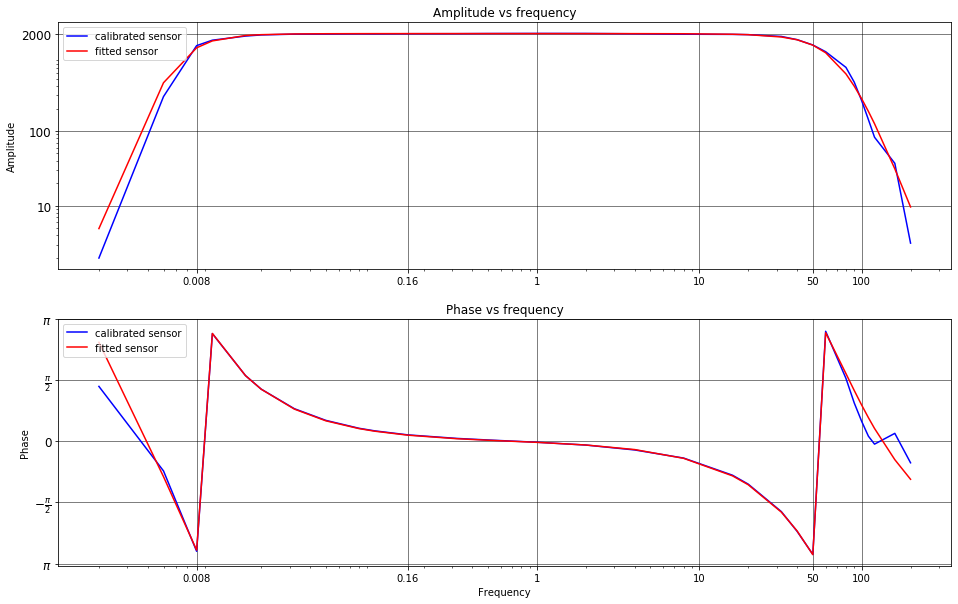

In [11]:
plt.figure(figsize = (16,10))
plt.rc('ytick', labelsize = 12)

plt.subplot(2,1,1)
plt.loglog(xdata, ydata, 'b', label = "calibrated sensor")
plt.loglog(xdata, abs(fin), 'r', label = "fitted sensor")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.yticks([10,100,2000],['10','100','2000'])
plt.xticks([0.008,0.16,1,10,50,100], ['0.008','0.16','1','10','50','100'])
plt.title("Amplitude vs frequency")
plt.ylabel('Amplitude')
plt.legend(loc = 'upper left')


plt.subplot(2,1,2)
plt.semilogx(xdata,np.angle(ydata_complex),'b', label = "calibrated sensor")
plt.semilogx(xdata,np.angle(final),'r', label = "fitted sensor")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.xticks([0.008,0.16,1,10,50,100], ['0.008','0.16','1','10','50','100'],fontsize=10)
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi], ['$\pi$',r'$-\frac{\pi}{2}$','0',r'$\frac{\pi}{2}$','$\pi$'])
plt.title("Phase vs frequency")
plt.ylabel('Phase')
plt.xlabel('Frequency')
plt.legend(loc = 'upper left')
plt.show()